흑백  이미지가 10개의 옷 종류로 분류돼 있는 FashionMNIST 데이터를 이용해 기본적 MLP구조의 AutoEncoder 모델 설계

### AutoEncoder 모델 설계 순서
1. 모듈 임포트
2. 딥러닝 모델을 설계할 때 활용할 장비 확인
3. FashionMNIST 데이터 다운(Train set, Test set 분리)
4. 데이터 확인
5. 데이터 확인
6. AE(AutoEncoder) 모델 설계
7. Optimizer, Objective Function 설정
8. AE 모델 학습을 진행하면서 학습 데이터에 대한 모델의 성능 확인하는 함수 정의
9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
10. AutoEncoder 학습을 실행하면서 Test set의 Reconstruction Error 확인 

In [1]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# 딥러닝 모델 설계시 활용 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0  Device: cpu


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
# FashionMNIST 데이터 다운로드(Train set, Test set 분리하기)
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)


100.0%


Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



In [7]:
# 데이터 확인하기
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


y_train: 32개의 이미지 데이터에 Label 값이 1개씩 존재하기 때문에 32개의 값을 지니고 있음

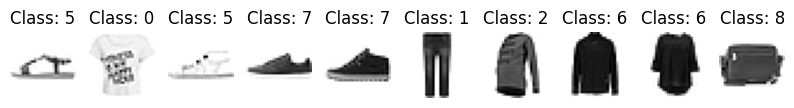

In [8]:
# 데이터 확인
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

데이터는 [Mini-Batch, Channel, Height, Width]의 형태로 1개의 Mini-Batch 내에는 32개의 데이터가 있고 채널이 1개 이며 세로 28 가로 28인 이미지 데이터를 가짐

In [9]:
# AutoEncoder(AE) 모델 설계
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 32))
        
        self.decoder = nn.Sequential(nn.Linear(32, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 28 * 28))
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# Optimizer, Objective Function 설정

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [18]:
# AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        
        optimizer.zero_grad()
        
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100 * batch_idx / len(train_loader), loss.item()))

loss = criterion(decoded, target) \n
loss.backward() \n
optimizer.step() \n

1. 계산된 Output과 장비에 할당된 이미지 데이터를 기존에 정의한 MeanSquaredError를 이용해 Loss 값을 계산
2. Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당
3. 각 파라미터 별로 할당된 Gradient 값을 이용해 파라미터 값을 업데이트

In [19]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 0.008498
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 0.009484
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 0.008734
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 0.009422
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 0.009392
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.008467
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 0.008928
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.010309
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.008228
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.009224

[EPOCH: 1], 	Test Loss: 0.0003


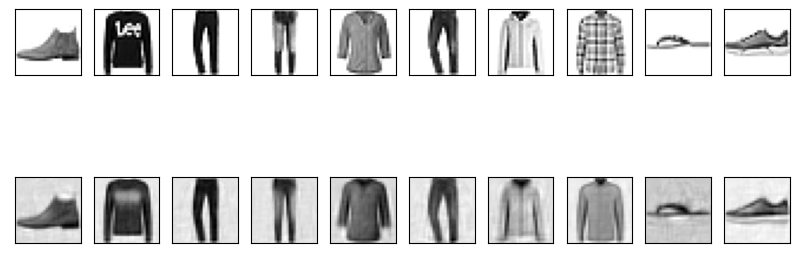

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 0.010794
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.009545
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.007813
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.012272
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.010054
Train Epoch: 2 [32000/60000(53%)] 	 Train Loss: 0.007854
Train Epoch: 2 [38400/60000(64%)] 	 Train Loss: 0.009580
Train Epoch: 2 [44800/60000(75%)] 	 Train Loss: 0.008514
Train Epoch: 2 [51200/60000(85%)] 	 Train Loss: 0.007031
Train Epoch: 2 [57600/60000(96%)] 	 Train Loss: 0.008868

[EPOCH: 2], 	Test Loss: 0.0003


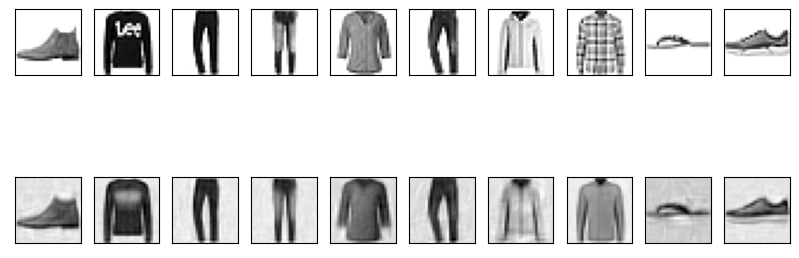

Train Epoch: 3 [0/60000(0%)] 	 Train Loss: 0.011510
Train Epoch: 3 [6400/60000(11%)] 	 Train Loss: 0.007673
Train Epoch: 3 [12800/60000(21%)] 	 Train Loss: 0.008979
Train Epoch: 3 [19200/60000(32%)] 	 Train Loss: 0.009035
Train Epoch: 3 [25600/60000(43%)] 	 Train Loss: 0.008161
Train Epoch: 3 [32000/60000(53%)] 	 Train Loss: 0.008636
Train Epoch: 3 [38400/60000(64%)] 	 Train Loss: 0.008179
Train Epoch: 3 [44800/60000(75%)] 	 Train Loss: 0.007350
Train Epoch: 3 [51200/60000(85%)] 	 Train Loss: 0.009264
Train Epoch: 3 [57600/60000(96%)] 	 Train Loss: 0.007705

[EPOCH: 3], 	Test Loss: 0.0003


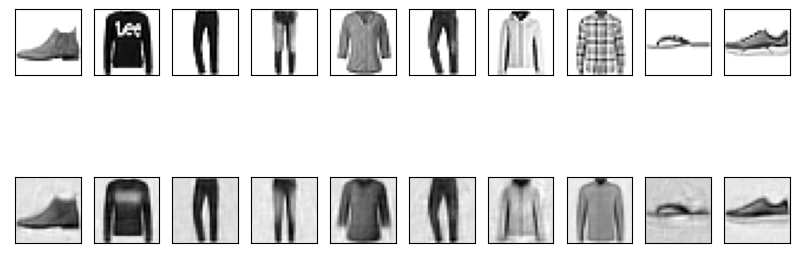

Train Epoch: 4 [0/60000(0%)] 	 Train Loss: 0.007564
Train Epoch: 4 [6400/60000(11%)] 	 Train Loss: 0.009175
Train Epoch: 4 [12800/60000(21%)] 	 Train Loss: 0.011295
Train Epoch: 4 [19200/60000(32%)] 	 Train Loss: 0.008877
Train Epoch: 4 [25600/60000(43%)] 	 Train Loss: 0.007884
Train Epoch: 4 [32000/60000(53%)] 	 Train Loss: 0.010125
Train Epoch: 4 [38400/60000(64%)] 	 Train Loss: 0.007244
Train Epoch: 4 [44800/60000(75%)] 	 Train Loss: 0.008365
Train Epoch: 4 [51200/60000(85%)] 	 Train Loss: 0.010201
Train Epoch: 4 [57600/60000(96%)] 	 Train Loss: 0.010138

[EPOCH: 4], 	Test Loss: 0.0003


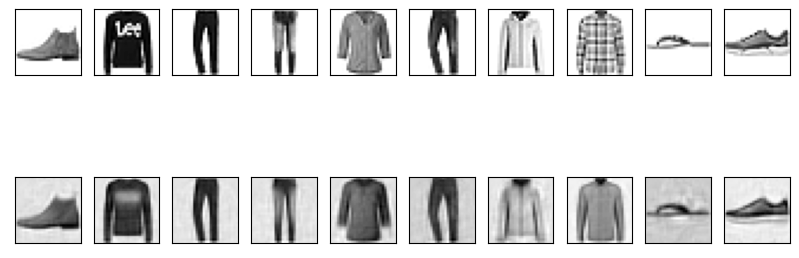

Train Epoch: 5 [0/60000(0%)] 	 Train Loss: 0.009680
Train Epoch: 5 [6400/60000(11%)] 	 Train Loss: 0.008274
Train Epoch: 5 [12800/60000(21%)] 	 Train Loss: 0.007138
Train Epoch: 5 [19200/60000(32%)] 	 Train Loss: 0.009009
Train Epoch: 5 [25600/60000(43%)] 	 Train Loss: 0.007692
Train Epoch: 5 [32000/60000(53%)] 	 Train Loss: 0.009624
Train Epoch: 5 [38400/60000(64%)] 	 Train Loss: 0.009469
Train Epoch: 5 [44800/60000(75%)] 	 Train Loss: 0.009097
Train Epoch: 5 [51200/60000(85%)] 	 Train Loss: 0.009042
Train Epoch: 5 [57600/60000(96%)] 	 Train Loss: 0.006682

[EPOCH: 5], 	Test Loss: 0.0003


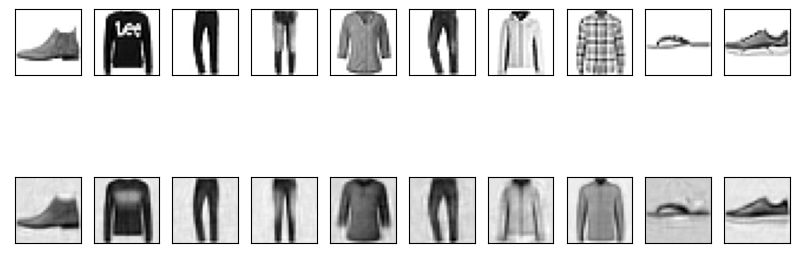

Train Epoch: 6 [0/60000(0%)] 	 Train Loss: 0.008974
Train Epoch: 6 [6400/60000(11%)] 	 Train Loss: 0.010004
Train Epoch: 6 [12800/60000(21%)] 	 Train Loss: 0.009431
Train Epoch: 6 [19200/60000(32%)] 	 Train Loss: 0.009354
Train Epoch: 6 [25600/60000(43%)] 	 Train Loss: 0.008775
Train Epoch: 6 [32000/60000(53%)] 	 Train Loss: 0.008339
Train Epoch: 6 [38400/60000(64%)] 	 Train Loss: 0.009306
Train Epoch: 6 [44800/60000(75%)] 	 Train Loss: 0.009571
Train Epoch: 6 [51200/60000(85%)] 	 Train Loss: 0.007750
Train Epoch: 6 [57600/60000(96%)] 	 Train Loss: 0.009666

[EPOCH: 6], 	Test Loss: 0.0003


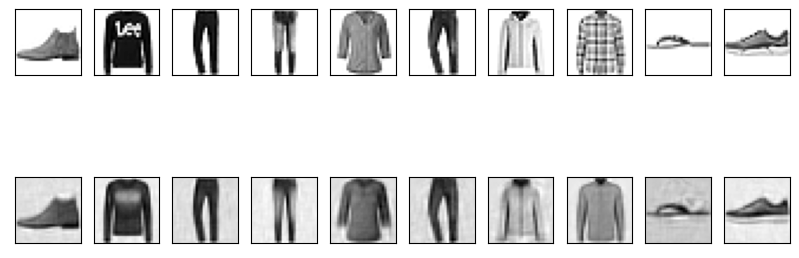

Train Epoch: 7 [0/60000(0%)] 	 Train Loss: 0.007421
Train Epoch: 7 [6400/60000(11%)] 	 Train Loss: 0.008482
Train Epoch: 7 [12800/60000(21%)] 	 Train Loss: 0.008067
Train Epoch: 7 [19200/60000(32%)] 	 Train Loss: 0.008398
Train Epoch: 7 [25600/60000(43%)] 	 Train Loss: 0.010776
Train Epoch: 7 [32000/60000(53%)] 	 Train Loss: 0.008007
Train Epoch: 7 [38400/60000(64%)] 	 Train Loss: 0.008203
Train Epoch: 7 [44800/60000(75%)] 	 Train Loss: 0.006911
Train Epoch: 7 [51200/60000(85%)] 	 Train Loss: 0.010008
Train Epoch: 7 [57600/60000(96%)] 	 Train Loss: 0.009391

[EPOCH: 7], 	Test Loss: 0.0003


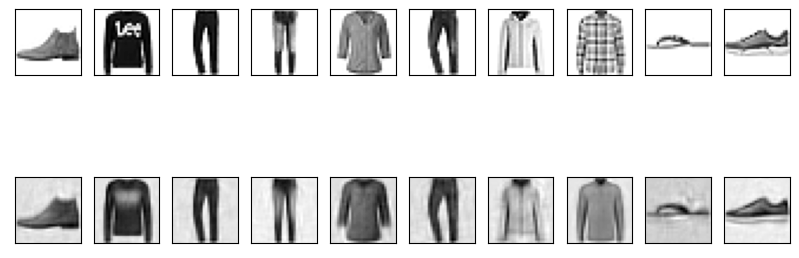

Train Epoch: 8 [0/60000(0%)] 	 Train Loss: 0.008611
Train Epoch: 8 [6400/60000(11%)] 	 Train Loss: 0.009227
Train Epoch: 8 [12800/60000(21%)] 	 Train Loss: 0.008151
Train Epoch: 8 [19200/60000(32%)] 	 Train Loss: 0.007850
Train Epoch: 8 [25600/60000(43%)] 	 Train Loss: 0.007948
Train Epoch: 8 [32000/60000(53%)] 	 Train Loss: 0.007457
Train Epoch: 8 [38400/60000(64%)] 	 Train Loss: 0.007947
Train Epoch: 8 [44800/60000(75%)] 	 Train Loss: 0.008139
Train Epoch: 8 [51200/60000(85%)] 	 Train Loss: 0.009703
Train Epoch: 8 [57600/60000(96%)] 	 Train Loss: 0.008390

[EPOCH: 8], 	Test Loss: 0.0003


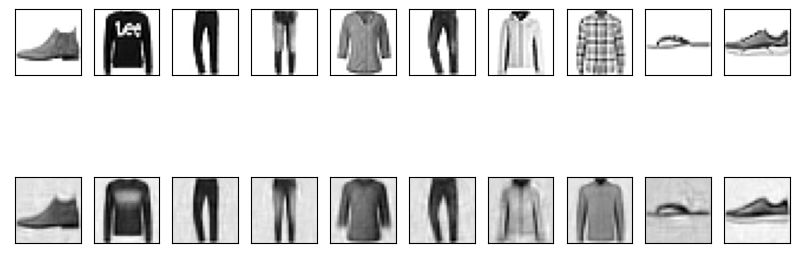

Train Epoch: 9 [0/60000(0%)] 	 Train Loss: 0.008530
Train Epoch: 9 [6400/60000(11%)] 	 Train Loss: 0.010123
Train Epoch: 9 [12800/60000(21%)] 	 Train Loss: 0.010629
Train Epoch: 9 [19200/60000(32%)] 	 Train Loss: 0.008968
Train Epoch: 9 [25600/60000(43%)] 	 Train Loss: 0.009267
Train Epoch: 9 [32000/60000(53%)] 	 Train Loss: 0.007638
Train Epoch: 9 [38400/60000(64%)] 	 Train Loss: 0.007774
Train Epoch: 9 [44800/60000(75%)] 	 Train Loss: 0.009059
Train Epoch: 9 [51200/60000(85%)] 	 Train Loss: 0.009087
Train Epoch: 9 [57600/60000(96%)] 	 Train Loss: 0.007414

[EPOCH: 9], 	Test Loss: 0.0003


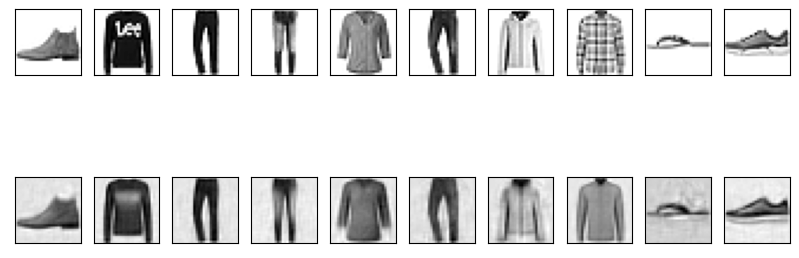

Train Epoch: 10 [0/60000(0%)] 	 Train Loss: 0.008082
Train Epoch: 10 [6400/60000(11%)] 	 Train Loss: 0.007617
Train Epoch: 10 [12800/60000(21%)] 	 Train Loss: 0.008081
Train Epoch: 10 [19200/60000(32%)] 	 Train Loss: 0.009913
Train Epoch: 10 [25600/60000(43%)] 	 Train Loss: 0.009195
Train Epoch: 10 [32000/60000(53%)] 	 Train Loss: 0.007990
Train Epoch: 10 [38400/60000(64%)] 	 Train Loss: 0.008750
Train Epoch: 10 [44800/60000(75%)] 	 Train Loss: 0.008597
Train Epoch: 10 [51200/60000(85%)] 	 Train Loss: 0.007732
Train Epoch: 10 [57600/60000(96%)] 	 Train Loss: 0.007474

[EPOCH: 10], 	Test Loss: 0.0003


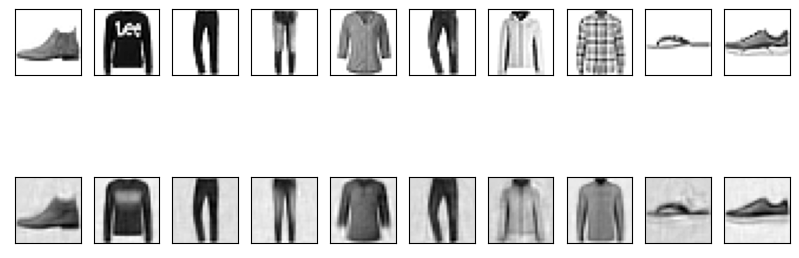

In [22]:
# AutoEncoder 학습을 실행하며 Test set의 Reconstruction Error 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
    
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    
    plt.show()